#### Predicting EIR and Incidence from Prevalence in 2-10years old and entire population

In [1]:
#Libraries importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
import time

2025-02-13 12:07:20.808748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 12:07:20.825835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 12:07:20.831085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 12:07:20.844874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 12:07:21.884145: W tensorflow/compiler/tf2

In [2]:
#setting seeds
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2025-02-13 12:07:22.734425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
#Importing functions from split_simulation script
from split_simulations import process_dataframe#annual_averages, monthly_values#(years_10-20)

In [7]:
# data loading 
df = pd.read_csv("sim_compendia_train/10000_runs/ANC_Simulation_10000_runs.csv", index_col=0).reset_index(drop=True)

In [8]:
df = process_dataframe(df)

#dataframe saved to CSV
df.to_csv("sim_compendia_train/10000_runs/processed_df.csv", index=False)

df.head()

,run,t,prev_true,EIR_true,vol_true,tested,positive,incall
0,1.0,720.0,0.197861,3.040653,0.8,223.583333,32.833333,0.000740
1,1.0,1800.0,0.733250,300.244881,0.8,225.833333,115.666667,0.007984
2,1.0,2880.0,0.574510,53.289959,0.8,227.083333,88.833333,0.000677
3,1.0,3660.0,0.418846,169.112468,0.8,259.000000,110.000000,0.004459
4,1.0,3690.0,0.462078,170.812027,0.8,278.000000,121.000000,0.003913


#### Exploratory Data Analysis

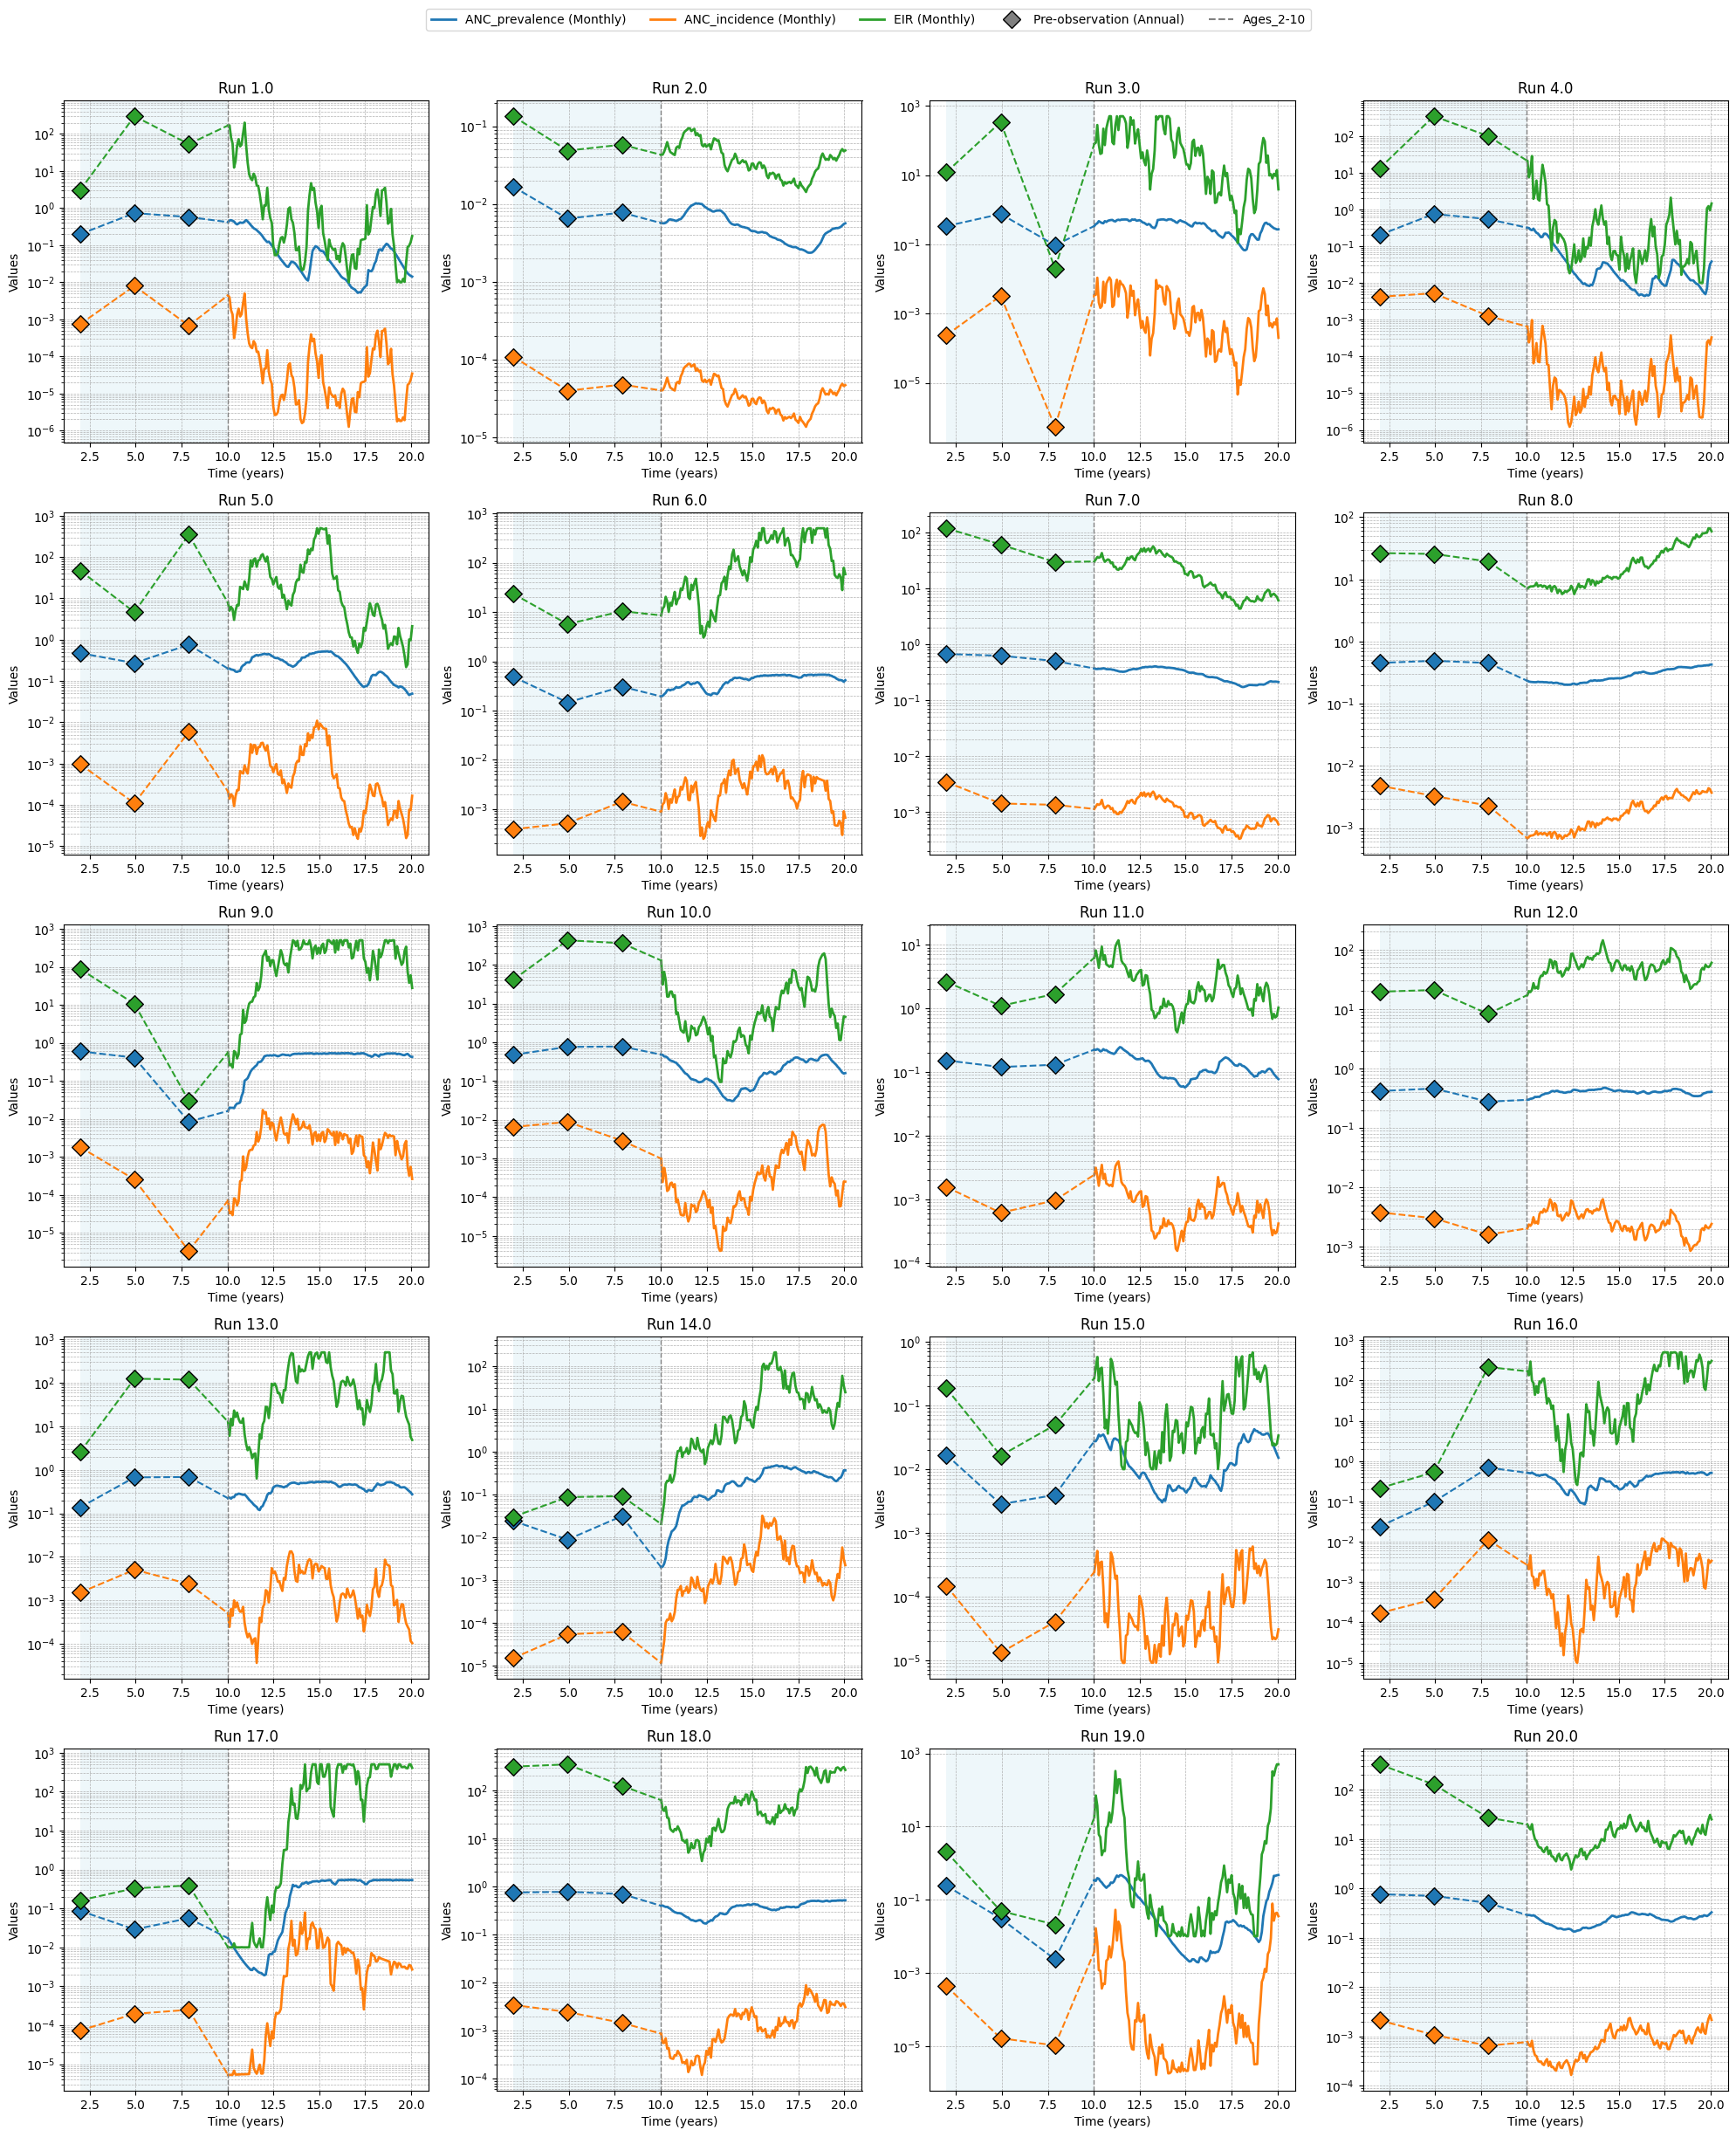

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_subplots_for_runs(df, num_runs=20):
    # Convert time column to years
    df = df.copy()
    df['t_years'] = df['t'] / 365  # Convert days to years
    
    # Select the first num_runs unique runs
    unique_runs = df['run'].unique()[:num_runs]
    columns_to_plot = ["prev_true", "incall", "EIR_true"]
    
    # Define distinct colors for the three columns
    color_map = {
        'prev_true': 'tab:blue',
        'incall': 'tab:orange',
        'EIR_true': 'tab:green'
    }
    
    # Define grid size for subplots (4 subplots per row)
    rows = (num_runs - 1) // 4 + 1
    cols = 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten for easy iteration
    
    for i, run in enumerate(unique_runs):
        ax = axes[i]
        # Extract and sort data for the run by time
        run_data = df[df['run'] == run].sort_values('t_years')
        
        # Separate pre-observation (annual averages) and monthly observation data
        pre_obs = run_data[run_data['t_years'] < 10].sort_values('t_years')  # 10 years
        monthly = run_data[run_data['t_years'] >= 10].sort_values('t_years')
        
        # Shade the pre-observation region with a soft color
        ax.axvspan(run_data['t_years'].min(), 10, facecolor='lightblue', alpha=0.2,
                   label='Pre-observation period' if i == 0 else None)
        
        # Plot monthly observation data as lines for each column
        for col in columns_to_plot:
            # Plot the monthly data as a solid line
            ax.plot(monthly['t_years'], monthly[col],
                    color=color_map[col],
                    lw=2,
                    label=f'{col} (Monthly)' if i == 0 else None)
            
            # Overlay the pre-observation points with diamond markers.
            if not pre_obs.empty:
                ax.scatter(pre_obs['t_years'], pre_obs[col],
                           color=color_map[col],
                           marker='D', s=100,
                           edgecolor='k',
                           zorder=5,
                           label='Pre-observation (Annual)' if i == 0 else None)
            
            # Connect all pre-observation points with dashed lines
            if len(pre_obs) > 1:
                pre_obs_times = pre_obs['t_years'].values
                pre_obs_vals = pre_obs[col].values
                for j in range(1, len(pre_obs_times)):
                    ax.plot([pre_obs_times[j-1], pre_obs_times[j]],
                            [pre_obs_vals[j-1], pre_obs_vals[j]],
                            color=color_map[col],
                            linestyle='--', lw=1.5, zorder=4)
            
            # Connect last pre-observation point to first monthly point if both exist
            if (not pre_obs.empty) and (not monthly.empty):
                last_pre = pre_obs.iloc[-1]
                first_month = monthly.iloc[0]
                ax.plot([last_pre['t_years'], first_month['t_years']],
                        [last_pre[col], first_month[col]],
                        color=color_map[col],
                        linestyle='--', lw=1.5, zorder=4)
        
        # Draw a vertical dashed line to clearly mark the boundary at t=10 years
        ax.axvline(x=10, color='grey', linestyle='--', lw=1)
        
        # Set the y-axis to a logarithmic scale for better comparison
        ax.set_yscale('log')
        
        # Set subplot title and labels
        ax.set_title(f'Run {run}')
        ax.set_xlabel('Time (years)')  # Updated label
        ax.set_ylabel('Values')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Hide any unused subplots
    for j in range(len(unique_runs), len(axes)):
        axes[j].axis('off')
    
    # Create a custom legend.
    custom_lines = [
        Line2D([0], [0], color=color_map['prev_true'], lw=2),
        Line2D([0], [0], color=color_map['incall'], lw=2),
        Line2D([0], [0], color=color_map['EIR_true'], lw=2),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='grey', markeredgecolor='k', markersize=10),
        Line2D([0], [0], color='grey', linestyle='--', lw=1.5)
    ]
    custom_labels = [
        'ANC_prevalence (Monthly)',
        'ANC_incidence (Monthly)',
        'EIR (Monthly)',
        'Pre-observation (Annual)',
        'Ages_2-10'
    ]
    
    # Place the universal legend at the top center
    fig.legend(custom_lines, custom_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to provide space for the legend
    plt.savefig('plots/Prevalence_plot_in_2-10_and_ANC.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_subplots_for_runs(df, num_runs=20)


In [8]:
train_data = df[df['run'] <= 9800] # 9950 runs used for 
eval_data = df[(df['run'] > 9800) & (df['run'] <= 9900)]
test_data = df[df['run'] > 9900]

In [9]:
train_data.head()

,run,t,prev_true,EIR_true,vol_true,tested,positive,incall
0,1.0,720.0,0.197861,3.040653,0.8,223.583333,32.833333,0.000740
1,1.0,1800.0,0.733250,300.244881,0.8,225.833333,115.666667,0.007984
2,1.0,2880.0,0.574510,53.289959,0.8,227.083333,88.833333,0.000677
3,1.0,3660.0,0.418846,169.112468,0.8,259.000000,110.000000,0.004459
4,1.0,3690.0,0.462078,170.812027,0.8,278.000000,121.000000,0.003913


In [10]:
# preprocessing (Log transform function)
def log_transform(data):
    return np.log(data)

# Inverse log transform function
def inverse_log_transform(data):
   return np.exp(data)

# # Log transforming our data
# train_data_scaled = train_data[["prev_true", "incall","EIR_true"]].apply(log_transform)#"prev_2to10",
# eval_data_scaled = eval_data[["prev_true", "incall", "EIR_true"]].apply(log_transform)#"prev_2to10", 
# test_data_scaled = test_data[["prev_true", "incall", "EIR_true"]].apply(log_transform)#"prev_2to10",

In [11]:
def transform_data(data, cols_to_transform, id_column, transform_func):
    
    # ID column and the columns to transform
    transformed_data = data[[id_column] + cols_to_transform].copy()
    
    # Appliny (log) transformation
    transformed_data[cols_to_transform] = transformed_data[cols_to_transform].apply(transform_func)
    
    return transformed_data

In [12]:
cols_to_transform = ["prev_true", "EIR_true", "incall"]
id_column = "run"

# Transform the datasets
train_data_scaled = transform_data(train_data, cols_to_transform, id_column, log_transform)
eval_data_scaled = transform_data(eval_data, cols_to_transform, id_column, log_transform)
test_data_scaled = transform_data(test_data, cols_to_transform, id_column, log_transform)

In [13]:
# Importing sequence function from script
from sequence_creator_multi_inputs_outputs import create_sequences

In [14]:
# Creating sequences
window_size = 10
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_eval, y_eval = create_sequences(eval_data_scaled, window_size)
X_test, y_test = create_sequences(test_data_scaled, window_size)

#saving sequences for resuablility
np.savez('src/seq/train_sequences.npz', X=X_train, y=y_train)
np.savez('src/seq/eval_sequences.npz', X=X_eval, y=y_eval)
np.savez('src/seq/test_sequences.npz', X=X_test, y=y_test)

# train_data = np.load('train_sequences.npz')
# X_train, y_train = train_data['X'], train_data['y']

# eval_data = np.load('eval_sequences.npz')
# X_eval, y_eval = eval_data['X'], eval_data['y']

In [15]:
#Shuffling training Sequences in Unison to introduce more randomness(volatility)
shuffled_indices = np.random.permutation(len(X_train))

X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [16]:
seq_length = 2*window_size + 1 

In [17]:
# Defining architectures to experiment with
architectures = {
    "2_layers": [128, 64],
    "3_layers": [200, 100, 50],
    "4_layers": [256, 128, 64, 32],
    "5_layers": [300, 200, 100, 50, 25],
    #"6_layers": [400, 300, 200, 100, 50, 25]
}

In [18]:
#loading model function
from model_exp import create_experiment_model

In [ ]:
# results tracking 
results = []
for name, architecture in architectures.items():
    print(f"Training model: {name}")
    model = create_experiment_model(seq_length, architecture)
    model.summary()
    start_time = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=15, batch_size=32, verbose=0)
    duration = time.time() - start_time
    results.append({
        "name": name,
        "model": model,
        "history": history,
        "duration": duration,
        "parameters": model.count_params()
    })
    model.save(f"src/model/{name}_model_10000runs_w10.keras")

Training model: 2_layers


2025-02-06 17:41:13.127494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22054 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:27:00.0, compute capability: 8.6
2025-02-06 17:41:13.128963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21442 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:28:00.0, compute capability: 8.6
2025-02-06 17:41:13.130062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22256 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:43:00.0, compute capability: 8.6
2025-02-06 17:41:13.131314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21840 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:44:00.0, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,098 (453.51 KB)

 Trainable params: 116,098 (453.51 KB)

 Non-trainable params: 0 (0.00 B)

2025-02-06 17:41:26.028383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


Training model: 3_layers


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 21, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 21, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,302 (1.19 MB)

 Trainable params: 312,302 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Training model: 4_layers


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 21, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 21, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 21, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,202 (2.00 MB)

 Trainable params: 523,202 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model names and metrics
model_names = [result['name'] for result in results]
parameters = [result['parameters'] for result in results]
durations = [result['duration'] for result in results]

# Normalized values for comparison
max_params = max(parameters)
max_durations = max(durations)
normalized_params = [p / max_params for p in parameters]
normalized_durations = [d / max_durations for d in durations]

#grouped bar plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(model_names))  # the label locations
bar_width = 0.4

# Plotting normalized values
bar1 = ax.bar(x - bar_width / 2, normalized_params, bar_width, label="Normalized Parameters", color="skyblue")
bar2 = ax.bar(x + bar_width / 2, normalized_durations, bar_width, label="Normalized Training Duration(seconds)", color="darkorange")

# Adding value annotations
for bar, param in zip(bar1, parameters):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{param:,}", ha="center", fontsize=10, color="blue")
for bar, duration in zip(bar2, durations):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{duration:.1f}", ha="center", fontsize=10, color="orange")

# Axis labels and title
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Normalized Values", fontsize=12)
ax.set_title("Comparison of Model Parameters and Training Durations", fontsize=14, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=10)
ax.legend(fontsize=10)

# Grid and layout
ax.grid(axis="y", linestyle="--", alpha=0.7)
fig.tight_layout()

plt.savefig("plots/Comparison of Model Parameters and Training Durations_updated.png", dpi=300)
plt.show()


In [ ]:
# Training and Validation Metrics (loss function)
for result in results:
    plt.figure(figsize=(10, 6))
    history = result['history']
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss: {result['name']}")
    plt.legend()
    plt.show()

In [ ]:
#Plot of Performance metrics

y_train_pred_list = [model.predict(X_train) for model in [result['model'] for result in results]]
y_eval_pred_list = [model.predict(X_eval) for model in [result['model'] for result in results]]

# Metrics calculation
metrics_data = []
for idx, result in enumerate(results):
    y_train_pred = y_train_pred_list[idx]
    y_eval_pred = y_eval_pred_list[idx]
    
    #metrics for training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    #metrics for evaluation set
    eval_r2 = r2_score(y_eval, y_eval_pred)
    eval_mse = mean_squared_error(y_eval, y_eval_pred)
    eval_rmse = np.sqrt(eval_mse)
    eval_mae = mean_absolute_error(y_eval, y_eval_pred)
    
    metrics_data.append({
        "Model": result['name'],
        "Train R²": train_r2, "Eval R²": eval_r2,
        "Train MSE": train_mse, "Eval MSE": eval_mse,
        "Train RMSE": train_rmse, "Eval RMSE": eval_rmse,
        "Train MAE": train_mae, "Eval MAE": eval_mae
    })

# Converting to structured form for visualization
metrics_df = pd.DataFrame(metrics_data)

# Plotting
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: R²
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train R²", "Eval R²"]),
            x="Model", y="value", hue="variable", palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("R² Score Comparison")
axes[0, 0].set_ylabel("R² Score")

# Subplot 2: MSE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MSE", "Eval MSE"]),
            x="Model", y="value", hue="variable", palette="magma", ax=axes[0, 1])
axes[0, 1].set_title("Mean Squared Error (MSE) Comparison")
axes[0, 1].set_ylabel("MSE")

# Subplot 3: RMSE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train RMSE", "Eval RMSE"]),
            x="Model", y="value", hue="variable", palette="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Root Mean Squared Error (RMSE) Comparison")
axes[1, 0].set_ylabel("RMSE")

# Subplot 4: MAE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MAE", "Eval MAE"]),
            x="Model", y="value", hue="variable", palette="cividis", ax=axes[1, 1])
axes[1, 1].set_title("Mean Absolute Error (MAE) Comparison")
axes[1, 1].set_ylabel("MAE")

#layout
fig.tight_layout()
plt.savefig("plots/models_performance_metrics_comparison_updated.png")
plt.show()
